In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 9.2 MB/s eta 0:00:00


In [39]:
import re
import contractions
from matplotlib import pyplot as plt
import numpy as np

### Uploading train data

In [4]:
train_tw = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

### Looking at the data

In [3]:
train_tw.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_tw.keyword.value_counts().index.to_list()

In [15]:
train_tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
locations = train_tw.location.value_counts().index.to_list()
print(locations)

In [10]:
train_tw.shape

(7613, 5)

In [24]:
train_tw.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
for row in range(3107, 3142):
    print (train_tw.loc[row, 'text'])

Fr cuz I risk being electrocuted every shower ?? https://t.co/nWQ6wJQk1z
Youth electrocuted in Khulna  | http://t.co/3EnyNdXpPm https://t.co/GQpi7jMKan via @sharethis
South Side factory where worker electrocuted pays $17000 penalty #Columbus - http://t.co/N8EzfCTfcE
Michael talking about when he was electrocuted omg #ROWYSOLouisville http://t.co/HxVfmoUhDM
@steveycheese99 @MapMyRun where you being electrocuted all the way round? The map sure looks like it.
I'm loving this classic barn shot! We may or may not have got electrocuted got stung a few times and stepped in... http://t.co/X6aSGRjsWC
got electrocuted last night at work for the first time in my life.... shit was weird ????
.@BBCNews .@mwlippert #SouthKorea Dogs prepared!Electrocutedboiling waterfur machine ALL STILL ALIVE http://t.co/3a50DhZ7YI
Just thought I'd let you all know...
It's probably not a good idea to plug in your hairdryer when it's wet you will be electrocuted.
MT @Earths_Voice Treatment of #tigers in #China is app

#### Let's have a look on the lengths of tweets.

<BarContainer object of 7613 artists>

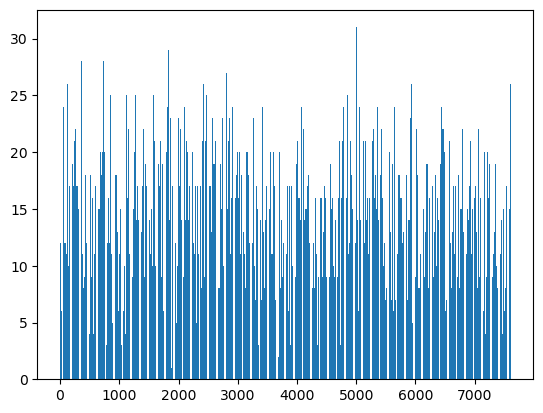

In [51]:
rows = np.arange(len(train_tw))
lengths = [len(tweet.split()) for tweet in train_tw['text']]

plt.bar(rows, lengths)

#### Let us now see the distribution of the tweets lengths in quantiles.

In [54]:
train_tw['tweet_length'] = [len(tweet.split()) for tweet in train_tw.text]
train_tw.head()

,id,keyword,location,text,target,text_length,tweet_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,16


In [59]:
train_tw.tweet_length.value_counts()

11    497
17    494
18    494
16    451
14    450
13    445
15    425
12    415
20    409
19    390
9     363
10    334
21    296
8     293
22    279
7     242
23    220
24    189
6     186
5     159
25    129
4     115
26     98
3      75
27     60
28     41
2      34
29     13
1       8
30      6
31      3
Name: tweet_length, dtype: int64

In [60]:
train_tw.tweet_length.nunique()

31

In [55]:
print(train_tw['tweet_length'].quantile([0.01, 0.05, 0.10, 0.5, 0.9, 0.95, 0.99]))

0.01     3.0
0.05     5.0
0.10     7.0
0.50    15.0
0.90    22.0
0.95    24.0
0.99    27.0
Name: tweet_length, dtype: float64


(array([  8.,  34.,  75., 115., 159., 186., 242., 293., 363., 334., 497.,
        415., 445., 450., 425., 451., 494., 494., 390., 409., 296., 279.,
        220., 189., 129.,  98.,  60.,  41.,  13.,   6.,   3.]),
 array([ 1.        ,  1.96774194,  2.93548387,  3.90322581,  4.87096774,
         5.83870968,  6.80645161,  7.77419355,  8.74193548,  9.70967742,
        10.67741935, 11.64516129, 12.61290323, 13.58064516, 14.5483871 ,
        15.51612903, 16.48387097, 17.4516129 , 18.41935484, 19.38709677,
        20.35483871, 21.32258065, 22.29032258, 23.25806452, 24.22580645,
        25.19354839, 26.16129032, 27.12903226, 28.09677419, 29.06451613,
        30.03225806, 31.        ]),
 <BarContainer object of 31 artists>)

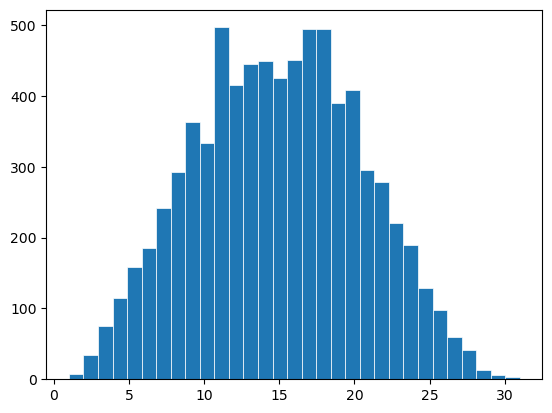

In [67]:
fig, ax = plt.subplots()

ax.hist(lengths, bins=31, linewidth=0.5, edgecolor="white")

# ax.set(xlim=(-1, 32), xticks=np.arange(-1, 32))

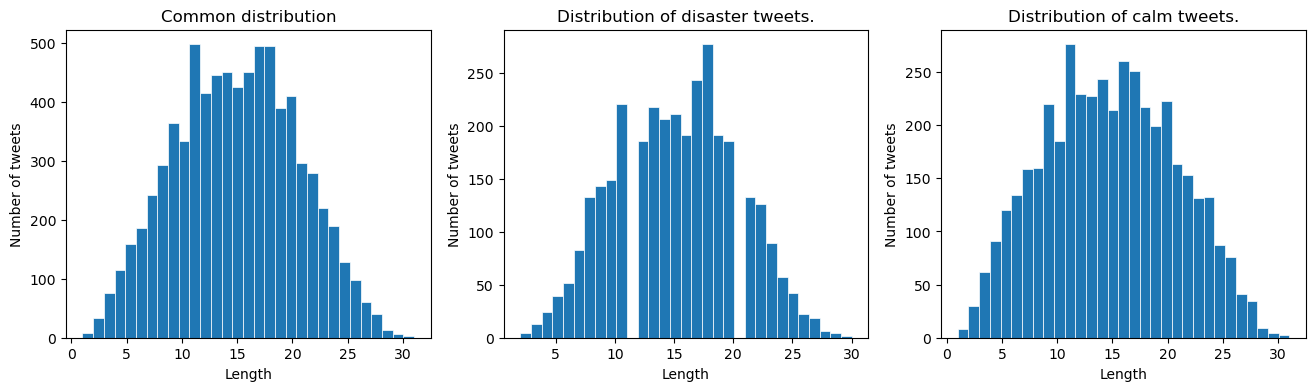

<Figure size 500x1000 with 0 Axes>

In [78]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
fig = plt.figure(figsize=(5, 10))

lengths = [len(tweet.split()) for tweet in train_tw['text']]
ax[0].hist(lengths, bins=31, linewidth=0.5, edgecolor="white")

lengths = [len(tweet.split()) for tweet in train_tw[train_tw['target'] == 1]['text']]
ax[1].hist(lengths, bins=31, linewidth=0.5, edgecolor="white")

lengths = [len(tweet.split()) for tweet in train_tw[train_tw['target'] == 0]['text']]
ax[2].hist(lengths, bins=31, linewidth=0.5, edgecolor="white")

names = ['Common distribution', 'Distribution of disaster tweets.',
         'Distribution of calm tweets.']
for i in range(len(names)):
    ax[i].set_title(names[i])
    ax[i].set_xlabel('Length')
    ax[i].set_ylabel('Number of tweets')

#### Processing tweets. Let us try to find in the tweets characteristic symbols, like as URL's, html's, special characters, @ etc. In case some of them are found, we remove them.

In [7]:
# We introduce counters for every matching found to see how many of them are found:
matches = {'URL': 0, 'html': 0, 'spec_char': 0, 'at': 0, 'hashtags': 0, 'non_ascii': 0,
           'multiples_!': 0, 'multiples_?': 0, 'typos': 0, 'acronyms': 0, 'abbr': 0}
        
# Patterns for URL's
https_pattern = re.compile(r"https?://\S+|www\.\S+")
# Patterns for html's
html_pattern = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
# Patterns for special characters
emoji_pattern = re.compile(
                            '['
                            u'\U0001F600-\U0001F64F'  # emoticons
                            u'\U0001F300-\U0001F5FF'  # symbols & pictographs
                            u'\U0001F680-\U0001F6FF'  # transport & map symbols
                            u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
                            u'\U00002702-\U000027B0'
                            u'\U000024C2-\U0001F251'
                            ']+',
                            flags=re.UNICODE
    )
# Patterns for character sequences with At symbol (@)
at_pattern = re.compile(r'@\S*')
# Patterns for hashtag symbols
hashtag_pattern = re.compile(r'#([^\s]+)')
# Patterns for non_ascii characters:
non_ascii_pattern = re.compile(r'[^\x00-\x7f]')
# Patterns for sequences of several '!'
multiples_pattern_1 = re.compile(r'!+')
# Patterns for sequences of several '?'
multiples_pattern_2 = re.compile(r'\?+')

# Taking into account typos, slang and other:
sample_typos_slang = {
                        "w/e": "whatever",
                        "usagov": "usa government",
                        "recentlu": "recently",
                        "ph0tos": "photos",
                        "amirite": "am i right",
                        "exp0sed": "exposed",
                        "<3": "love",
                        "luv": "love",
                        "amageddon": "armageddon",
                        "trfc": "traffic",
                        "16yr": "16 year"
                        }
sample_typos_slang_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) \
                            for key in sample_typos_slang.keys()) + r')(?!\w)')

# Acronyms
sample_acronyms =  { 
                    "mh370": "malaysia airlines flight 370",
                    "okwx": "oklahoma city weather",
                    "arwx": "arkansas weather",    
                    "gawx": "georgia weather",  
                    "scwx": "south carolina weather",  
                    "cawx": "california weather",
                    "tnwx": "tennessee weather",
                    "azwx": "arizona weather",  
                    "alwx": "alabama weather",
                    "usnwsgov": "united states national weather service",
                    "2mw": "tomorrow"
                    }
sample_acronyms_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) \
                            for key in sample_acronyms.keys()) + r')(?!\w)')

# Some common english abbreviations: 
sample_abbr = {     "$" : " dollar ",
                    "€" : " euro ",
                    "4ao" : "for adults only",
                    "a.m" : "before midday",
                    "a3" : "anytime anywhere anyplace",
                    "aamof" : "as a matter of fact",
                    "acct" : "account",
                    "adih" : "another day in hell",
                    "afaic" : "as far as i am concerned",
                    "afaict" : "as far as i can tell",
                    "afaik" : "as far as i know",
                    "afair" : "as far as i remember",
                    "afk" : "away from keyboard",
                    "app" : "application",
                    "approx" : "approximately",
                    "apps" : "applications",
                    "asap" : "as soon as possible",
                    "asl" : "age, sex, location",
                    "atk" : "at the keyboard",
                    "ave." : "avenue",
                    "aymm" : "are you my mother",
                    "ayor" : "at your own risk", 
                    "b&b" : "bed and breakfast",
                    "b+b" : "bed and breakfast",
                    "b.c" : "before christ",
                    "b2b" : "business to business",
                    "b2c" : "business to customer",
                    "b4" : "before",
                    "b4n" : "bye for now",
                    "b@u" : "back at you",
                    "bae" : "before anyone else",
                    "bak" : "back at keyboard",
                    "bbbg" : "bye bye be good",
                    "bbc" : "british broadcasting corporation",
                    "bbias" : "be back in a second",
                    "bbl" : "be back later",
                    "bbs" : "be back soon",
                    "be4" : "before",
                    "bfn" : "bye for now",
                    "blvd" : "boulevard",
                    "bout" : "about",
                    "brb" : "be right back",
                    "bros" : "brothers",
                    "brt" : "be right there",
                    "bsaaw" : "big smile and a wink",
                    "btw" : "by the way",
                    "bwl" : "bursting with laughter",
                    "c/o" : "care of",
                    "cet" : "central european time",
                    "cf" : "compare",
                    "cia" : "central intelligence agency",
                    "csl" : "can not stop laughing",
                    "cu" : "see you",
                    "cul8r" : "see you later",
                    "cv" : "curriculum vitae",
                    "cwot" : "complete waste of time",
                    "cya" : "see you",
                    "cyt" : "see you tomorrow",
                    "dae" : "does anyone else",
                    "dbmib" : "do not bother me i am busy",
                    "diy" : "do it yourself",
                    "dm" : "direct message",
                    "dwh" : "during work hours",
                    "e123" : "easy as one two three",
                    "eet" : "eastern european time",
                    "eg" : "example",
                    "embm" : "early morning business meeting",
                    "encl" : "enclosed",
                    "encl." : "enclosed",
                    "etc" : "and so on",
                    "faq" : "frequently asked questions",
                    "fawc" : "for anyone who cares",
                    "fb" : "facebook",
                    "fc" : "fingers crossed",
                    "fig" : "figure",
                    "fimh" : "forever in my heart", 
                    "ft." : "feet",
                    "ft" : "featuring",
                    "ftl" : "for the loss",
                    "ftw" : "for the win",
                    "fwiw" : "for what it is worth",
                    "fyi" : "for your information",
                    "g9" : "genius",
                    "gahoy" : "get a hold of yourself",
                    "gal" : "get a life",
                    "gcse" : "general certificate of secondary education",
                    "gfn" : "gone for now",
                    "gg" : "good game",
                    "gl" : "good luck",
                    "glhf" : "good luck have fun",
                    "gmt" : "greenwich mean time",
                    "gmta" : "great minds think alike",
                    "gn" : "good night",
                    "g.o.a.t" : "greatest of all time",
                    "goat" : "greatest of all time",
                    "goi" : "get over it",
                    "gps" : "global positioning system",
                    "gr8" : "great",
                    "gratz" : "congratulations",
                    "gyal" : "girl",
                    "h&c" : "hot and cold",
                    "hp" : "horsepower",
                    "hr" : "hour",
                    "hrh" : "his royal highness",
                    "ht" : "height",
                    "ibrb" : "i will be right back",
                    "ic" : "i see",
                    "icq" : "i seek you",
                    "icymi" : "in case you missed it",
                    "idc" : "i do not care",
                    "idgadf" : "i do not give a damn fuck",
                    "idgaf" : "i do not give a fuck",
                    "idk" : "i do not know",
                    "ie" : "that is",
                    "i.e" : "that is",
                    "ifyp" : "i feel your pain",
                    "IG" : "instagram",
                    "iirc" : "if i remember correctly",
                    "ilu" : "i love you",
                    "ily" : "i love you",
                    "imho" : "in my humble opinion",
                    "imo" : "in my opinion",
                    "imu" : "i miss you",
                    "iow" : "in other words",
                    "irl" : "in real life",
                    "j4f" : "just for fun",
                    "jic" : "just in case",
                    "jk" : "just kidding",
                    "jsyk" : "just so you know",
                    "l8r" : "later",
                    "lb" : "pound",
                    "lbs" : "pounds",
                    "ldr" : "long distance relationship",
                    "lmao" : "laugh my ass off",
                    "lmfao" : "laugh my fucking ass off",
                    "lol" : "laughing out loud",
                    "ltd" : "limited",
                    "ltns" : "long time no see",
                    "m8" : "mate",
                    "mf" : "motherfucker",
                    "mfs" : "motherfuckers",
                    "mfw" : "my face when",
                    "mofo" : "motherfucker",
                    "mph" : "miles per hour",
                    "mr" : "mister",
                    "mrw" : "my reaction when",
                    "ms" : "miss",
                    "mte" : "my thoughts exactly",
                    "nagi" : "not a good idea",
                    "nbc" : "national broadcasting company",
                    "nbd" : "not big deal",
                    "nfs" : "not for sale",
                    "ngl" : "not going to lie",
                    "nhs" : "national health service",
                    "nrn" : "no reply necessary",
                    "nsfl" : "not safe for life",
                    "nsfw" : "not safe for work",
                    "nth" : "nice to have",
                    "nvr" : "never",
                    "nyc" : "new york city",
                    "oc" : "original content",
                    "og" : "original",
                    "ohp" : "overhead projector",
                    "oic" : "oh i see",
                    "omdb" : "over my dead body",
                    "omg" : "oh my god",
                    "omw" : "on my way",
                    "p.a" : "per annum",
                    "p.m" : "after midday",
                    "pm" : "prime minister",
                    "poc" : "people of color",
                    "pov" : "point of view",
                    "pp" : "pages",
                    "ppl" : "people",
                    "prw" : "parents are watching",
                    "ps" : "postscript",
                    "pt" : "point",
                    "ptb" : "please text back",
                    "pto" : "please turn over",
                    "qpsa" : "what happens", #"que pasa",
                    "ratchet" : "rude",
                    "rbtl" : "read between the lines",
                    "rlrt" : "real life retweet", 
                    "rofl" : "rolling on the floor laughing",
                    "roflol" : "rolling on the floor laughing out loud",
                    "rotflmao" : "rolling on the floor laughing my ass off",
                    "rt" : "retweet",
                    "ruok" : "are you ok",
                    "sfw" : "safe for work",
                    "sk8" : "skate",
                    "smh" : "shake my head",
                    "sq" : "square",
                    "srsly" : "seriously", 
                    "ssdd" : "same stuff different day",
                    "tbh" : "to be honest",
                    "tbs" : "tablespooful",
                    "tbsp" : "tablespooful",
                    "tfw" : "that feeling when",
                    "thks" : "thank you",
                    "tho" : "though",
                    "thx" : "thank you",
                    "tia" : "thanks in advance",
                    "til" : "today i learned",
                    "tl;dr" : "too long i did not read",
                    "tldr" : "too long i did not read",
                    "tmb" : "tweet me back",
                    "tntl" : "trying not to laugh",
                    "ttyl" : "talk to you later",
                    "u.s." : 'usa',
                    "u" : "you",
                    "u2" : "you too",
                    "u4e" : "yours for ever",
                    "utc" : "coordinated universal time",
                    "w/" : "with",
                    "w/o" : "without",
                    "w8" : "wait",
                    "wassup" : "what is up",
                    "wb" : "welcome back",
                    "wtf" : "what the fuck",
                    "wtg" : "way to go",
                    "wtpa" : "where the party at",
                    "wuf" : "where are you from",
                    "wuzup" : "what is up",
                    "wywh" : "wish you were here",
                    "yd" : "yard",
                    "ygtr" : "you got that right",
                    "ynk" : "you never know",
                    "zzz" : "sleeping bored and tired"
                    }
sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) \
                            for key in sample_abbr.keys()) + r')(?!\w)')

def find_all_URL(text):
    match_obj = re.findall(https_pattern, text)
    matches['URL'] += len(match_obj)

def remove_URL(text):
    # Remove URL's from the string text:
    text = re.sub(https_pattern, "", text)
    return text

def find_all_html(text):
    match_obj = re.findall(html_pattern, text)
    matches['html'] += len(match_obj)

def remove_html(text):
    # Remove html from the string text:
    text = re.sub(html_pattern, "", text)
    return text

def find_all_spec_char(text):
    match_obj = re.findall(emoji_pattern, text)
    matches['spec_char'] += len(match_obj)

def remove_spec_char(text):
    # Remove special characters (like emojis and different graphic characters):
    text = emoji_pattern.sub(r'', text)
    return text

def find_all_at(text):
    match_obj = at_pattern.findall(text)
    matches['at'] += len(match_obj)

def remove_at(text):
    text = at_pattern.sub(r'', text)
    return text

def find_all_hashtags(text):
    match_obj = hashtag_pattern.findall(text)
    matches['hashtags'] += len(match_obj)

def remove_hashtags(text):
    # Remove hashtags from the string text:
    text = hashtag_pattern.sub(r'\1', text)
    return text

def find_all_non_ascii(text):
    match_obj = non_ascii_pattern.findall(text)
    matches['non_ascii'] += len(match_obj)

def remove_non_ascii(text):
    # Remove non-ASCII characters from the string text
    text = non_ascii_pattern.sub(r'', text)
    return text

def find_all_multiples(text):
    match_obj_1 = multiples_pattern_1.findall(text)
    matches['multiples_!'] += len(match_obj_1)
    
    match_obj_2 = multiples_pattern_2.findall(text)
    matches['multiples_?'] += len(match_obj_2)

def remove_multiples(text):
    text = multiples_pattern_1.sub(r'!', text)
    text = multiples_pattern_2.sub(r'?', text)
    return text

def remove_punct(text):
    # Remove all punctuation characters except dot '.':
    return re.sub(r'[]!"$%&\'()*+,/:;=#@?[\\^_`{|}~-]+', "", text)

def find_all_the_rest(text):
    modif_obj = sample_typos_slang_pattern.findall(text)
    matches['typos'] += len(modif_obj)
    
    modif_obj = sample_acronyms_pattern.findall(text)
    matches['acronyms'] += len(modif_obj)
    
    modif_obj = sample_abbr_pattern.findall(text)
    matches['abbr'] += len(modif_obj)
    
def remove_the_rest(text): 
    text = sample_typos_slang_pattern.sub(lambda x: sample_typos_slang[x.group()], text)
    text = sample_acronyms_pattern.sub(lambda x: sample_acronyms[x.group()], text)
    text = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], text)
    return text
  
def determine_quantities(text):
    find_all_URL(text)
    find_all_html(text)
    find_all_spec_char(text)
    find_all_at(text)
    find_all_hashtags(text)
    find_all_non_ascii(text)
    find_all_multiples(text)
    find_all_the_rest(text)
        
def process_text(text):
    text = remove_URL(text)
    text = remove_html(text)
    text = remove_spec_char(text)
    text = remove_at(text)  # At symbols (@) with following ater it alphanumerical characters
    text = remove_hashtags(text)
    text = remove_non_ascii(text)
    text = remove_multiples(text) # Remove repeated characters '!' and '?'
#     text = remove_punct(text)
    text = text.lower()
    text = remove_the_rest(text)
    text = contractions.fix(text) # Remove english contractions with the 'contractions' module
    text = text.strip()
    return text

In [35]:
for key in matches.keys():
    matches[key] = 0

modified_text = process_text("BREAKING: Fairfax County firefighter placed on admin leave amid probe into Facebook post about putting police in 'body bags' dept. says.")
print(modified_text)
for key in matches.keys():
    print(f'В тестовом выражении найдено {key}\'с: {matches[key]}.')

breaking: fairfax county firefighter placed on admin leave amid probe into facebook post about putting police in 'body bags' dept. says.
Найдено URL'с: 0.
Найдено html'с: 0.
Найдено spec_char'с: 0.
Найдено hashtags'с: 0.
Найдено typos'с: 0.
Найдено acronyms'с: 0.
Найдено abbr'с: 0.
Найдено non_ascii'с: 0.


#### We calculate now the quantities of all kinds of characteristic symbols in all the given tweets.

In [9]:
for key in matches.keys():
    matches[key] = 0

train_tw.text.apply(determine_quantities)

print('В твиттах найдено:')
for key in matches.keys():
    print(f'{key}: {matches[key]}')

В твиттах найдено:
URL: 4723
html: 457
spec_char: 0
at: 2751
hashtags: 3375
non_ascii: 2274
multiples_!: 905
multiples_?: 1255
typos: 35
acronyms: 19
abbr: 326


#### Let us remove all or some of them.

In [17]:
train_tw.text = train_tw.text.apply(process_text)

In [18]:
for row in range(1017, 1042):
    print (train_tw.loc[row, 'text'])

@slikrickdarula drake really body bagging peeps man ? he really about it
@foxnews @jengriffinfnc when you call to report dangerous activity tell them to have body bags on arrival.
micom 2015 summer contrast candy color bowknot cross body tote shoulder bags for womengirls with micom zip po
hobo hobo vintage shira convertible b_ $238.00 bestseller
child shoulder bags pvc shoulder book bag cartoon cross body bags for girls
womens buckle casual stylish shoulder handbags pockets cross body bags green
are not no bags in the trunk it is a body
bestseller! fossil dawson mini cross body bag es_ $98.00
@boomerangtime @rskarim1 @sopameer @wattashit3 appears to already be arriving in ridah in body bags.
the body bags has a show on 08/07/2015 at 07:30 prime minister @ tremont music hall in charlotte nc  concert
body bags!
you know you hate your body when you buy 2 bags of chips and a variety pack of fruit snacks and a redbull as a snack
breaking: fairfax county firefighter placed on admin leave ami

#### Transforming the type of all the cells in the columns 'keyword' and 'location' to str.

In [ ]:
train_tw.keyword = train_tw['keyword'].astype('str')
train_tw.location = train_tw['location'].astype('str')

#### Let's remove rows with empty cells. And in one case, we will try to remove from the data observations without a specified keyword. In another cas, we will try to leave them.

In [ ]:
train_tw = train_tw[train_tw['keyword'] != 'nan']
train_tw.dropna(subset='target')
train_tw.dropna(subset='text')

In [ ]:
train_tw